In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium
import cookiedisaster

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        # buffer uses deque for FIFO operations
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        # append the transition to deque; if the buffer is full, the oldest transition is automatically removed
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        # randomly sample batch_size elements from the buffer
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state)

    def __len__(self):
        return len(self.buffer)

In [3]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_observations, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)
        )

    def forward(self, state):
        return self.network(state)

In [4]:
class DQNAgent:
    def __init__(self, input_dim, action_space, buffer_size=1000000, batch_size=64, update_target_every=1000):
        self.policy_net = DQN(input_dim, action_space)
        self.target_net = DQN(input_dim, action_space)
        # copy the weights from the policy network to the target network
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-4)
        self.gamma = 0.99
        self.epsilon = 0.1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        # replay buffer to store transitions
        self.buffer = ReplayBuffer(buffer_size)
        # batch size for sampling from the buffer
        self.batch_size = batch_size
        # how often to update the target network
        self.update_target_every = update_target_every
        # counter to keep track of when to update the target network
        self.step_count = 0

    def select_action(self, state):
        # epsilon-greedy policy for action selection
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.policy_net.network[-1].out_features)
        else:
            state = torch.FloatTensor([state])
            q_values = self.policy_net(state)
            return torch.argmax(q_values).item()

    def train(self, state, action, reward, next_state):
        # store the transition in the replay buffer
        self.buffer.push(state, action, reward, next_state)

        # only start training if the buffer has enough samples
        if len(self.buffer) < self.batch_size:
            return

        # sample a batch of transitions from the buffer
        states, actions, rewards, next_states = self.buffer.sample(self.batch_size)
        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)

        # compute the current Q-values and the next Q-values
        current_q = self.policy_net(states).gather(1, actions).squeeze(1)
        next_q = self.target_net(next_states).max(1)[0]
        expected_q = rewards + self.gamma * next_q

        # compute the loss and perform a gradient descent step
        loss = nn.MSELoss()(current_q, expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.step_count += 1
        # periodically update the target network
        if self.step_count % self.update_target_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def save(self):
        torch.save(self.policy_net.state_dict(), "policy_net.pth")
        # torch.save(self.target_net.state_dict(), "target_net.pth")

    def load(self):
        self.policy_net.load_state_dict(torch.load("policy_net.pth"))
        # self.target_net.load_state_dict(torch.load("target_net.pth"))

In [5]:
def get_features(obs, info):
    agent_pos = obs["agent"]["pos"]
    agent_vel = obs["agent"]["vel"]
    cookie_pos = obs["cookie"]["pos"]
    cookie_time = obs["cookie"]["time"]
    dist = info["distance"]

    return [agent_pos, agent_vel, cookie_pos, cookie_time, dist]

In [6]:
def randomize_environment():
    images = ["cookie", "cake", "scone"]
    width_range = (1, 30)
    lifetime_range = (1, 15)
    friction_coefficient_range = (0.0001, 0.2)

    # generate random configuration
    config = {
        "img": random.choice(images),
        "width": np.random.randint(*width_range),
        "lifetime": np.random.randint(*lifetime_range),
        "friction": lambda vel: - abs(vel) * vel * np.random.uniform(*friction_coefficient_range)
    }

    # create and return the environment with the random configuration
    env = gymnasium.make("cookiedisaster-v3", render_mode="rgb_array", config=config)
    return env

In [9]:
env = gymnasium.make("cookiedisaster-v3", render_mode="rgb_array")

n_observations = len(get_features(*env.reset()))
n_actions = env.action_space.n

agent = DQNAgent(n_observations, n_actions)

In [10]:
def train_agent(agent, num_episodes=1000, max_steps_per_episode=2000):
    episode_rewards = []
    episode_cookies_collected = []

    for episode in range(num_episodes):
        env = randomize_environment()

        obs, info = env.reset()
        state = get_features(obs, info)
        episode_reward = 0
        cookies_collected = 0

        for step in range(max_steps_per_episode):
            action = agent.select_action(state)
            next_obs, reward, _, _, next_info = env.step(action)
            next_state = get_features(next_obs, next_info)
            agent.train(state, action, reward, next_state)

            if reward == 1:
                cookies_collected += 1

            episode_reward += reward
            state = next_state

        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

        episode_rewards.append(episode_reward)
        episode_cookies_collected.append(cookies_collected)
        print(f"\rEpisode: {episode + 1}   Reward: {episode_reward:.3f}   Epsilon: {agent.epsilon:.3f}", end="")

    return {
        "episode_rewards": episode_rewards,
        "episode_cookies_collected": episode_cookies_collected
    }

In [12]:
results = train_agent(agent)

Episode: 1000   Reward: 250.532   Epsilon: 0.010

In [13]:
agent.save()

In [14]:
cmap = sns.color_palette("magma", n_colors=15)

In [15]:
def plot_learning_performance(results, title):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(results["episode_rewards"], color=cmap[12], label="Episode Reward")
    axs[0].plot(pd.Series(results["episode_rewards"]).rolling(50).mean(), color=cmap[9],
                label="50-Episode Rolling Mean")
    axs[0].set_title(f"Episode Rewards over Time")
    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("Total Reward")
    axs[0].grid(color="silver", linestyle='--', linewidth=0.5)
    axs[0].legend()

    axs[1].plot(results["episode_cookies_collected"], color=cmap[6])
    axs[1].set_title("Cookies Collected per Episode")
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Cookies Collected")
    axs[1].grid(color="silver", linestyle='--', linewidth=0.5)

    fig.suptitle(title)

    plt.tight_layout()
    plt.show()

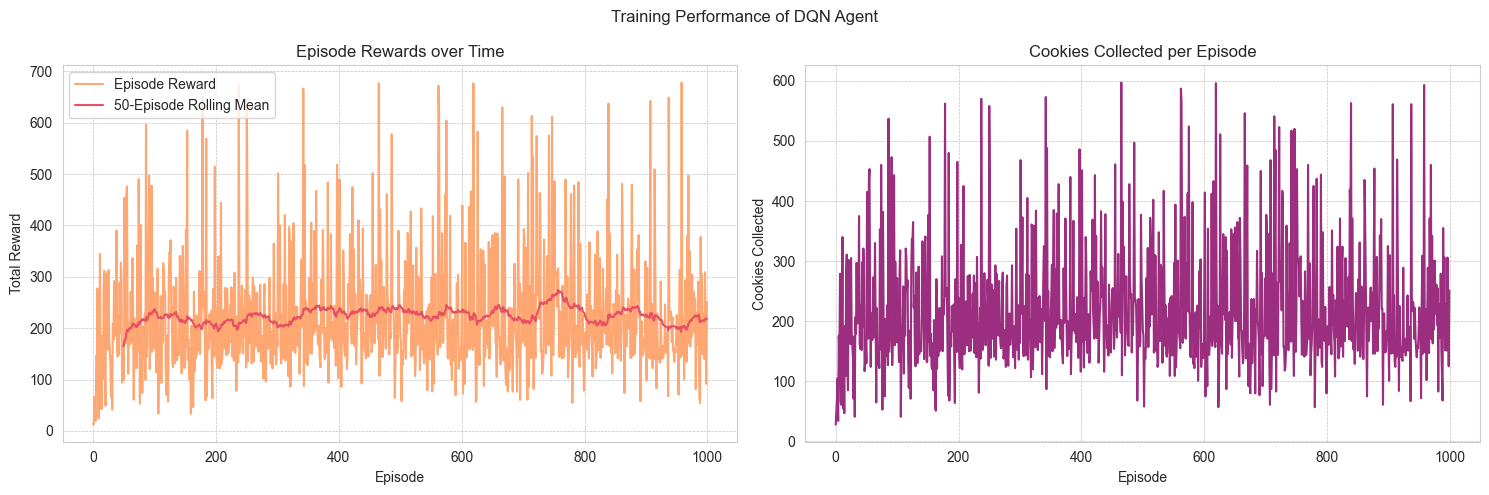

In [16]:
plot_learning_performance(results, title="Training Performance of DQN Agent")

In [ ]:
agent.load()

In [17]:
test_config = {"img": "cookie", "width": 40, "lifetime": 8, "friction": lambda vel: - abs(vel) * vel * 0.0005}
test_env = gymnasium.make("cookiedisaster-v3", render_mode="rgb_array")

In [18]:
def evaluate_agent(agent, env, num_episodes=1000, max_steps_per_episode=1000):
    episode_rewards = []
    episode_cookies_collected = []

    for episode in range(num_episodes):
        obs, info = env.reset()
        state = get_features(obs, info)
        episode_reward = 0
        cookies_collected = 0

        for step in range(max_steps_per_episode):
            action = agent.select_action(state)
            next_obs, reward, _, _, next_info = env.step(action)
            state = get_features(next_obs, next_info)

            if reward == 1:
                cookies_collected += 1

            episode_reward += reward

        episode_rewards.append(episode_reward)
        episode_cookies_collected.append(cookies_collected)
        print(f"\rEpisode: {episode + 1}   Reward: {episode_reward:.3f}", end="")
    return {
        "episode_rewards": episode_rewards,
        "episode_cookies_collected": episode_cookies_collected
    }

In [19]:
eval_results = evaluate_agent(agent, test_env)

Episode: 1000   Reward: 109.324

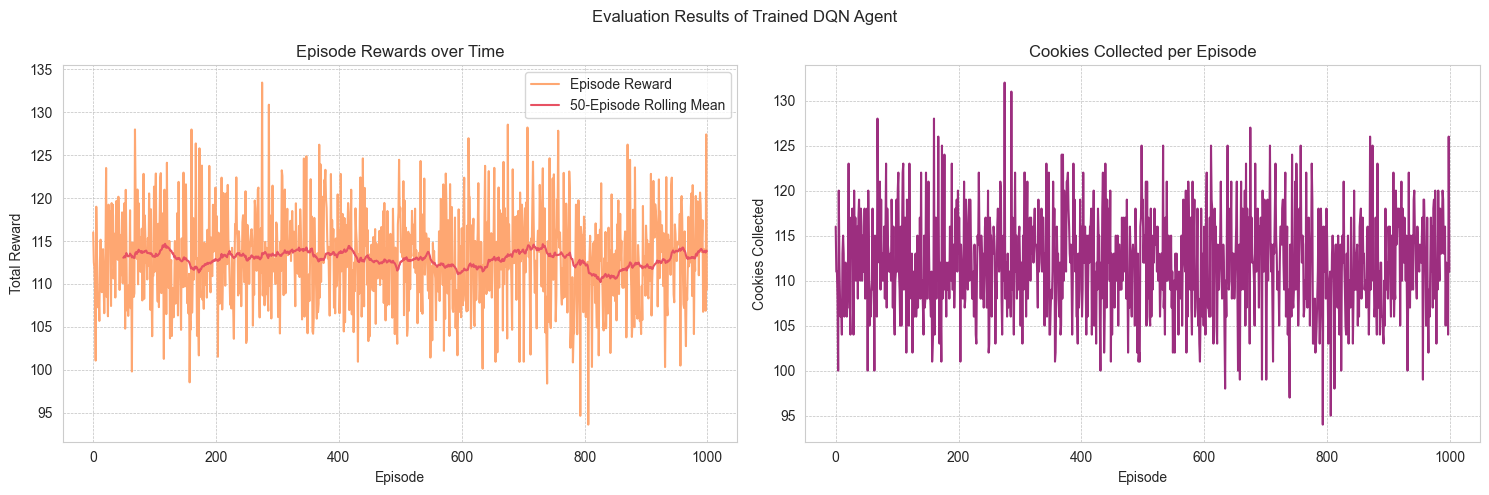

In [20]:
plot_learning_performance(eval_results, title="Evaluation Results of Trained DQN Agent")